# Array Size Calculation

In [1]:
import numpy as np

In [2]:
SystemCapacity = 340 #kW, for solar
panel_nameplate = .380 # kW
nSections = 4

# Module Sizes
# Portrait mode, typically x = 1 and y =2 for this. For landscape, rotate numbers.
x = 1 # Module size parallel to ground
y = 2 # Module edge in the Z direction. 

pitch = 8 # a.k.a. row-to-row distance
xgap = 1 # module-to-module space along the row axis. 
         # This account for the sleds, racking, as well as increase diffuse light in the array/minimize shading.


In [3]:
nPanels = np.round(SystemCapacity/panel_nameplate/4)*4  # 4 sections (NSEW), that's why dividing and rounding so it is a number dividable by 4. 
sectionnPanels = nPanels/nSections

print("Panels in Field", int(nPanels))
print("Panels per section ", int(sectionnPanels))

Panels in Field 896
Panels per section  224


In [4]:
squareness = int(pitch/(x+xgap))
print("nMods has to be ~", squareness, "x nRows for 'squareness'")

nMods has to be ~ 4 x nRows for 'squareness'


In [5]:
nMods = int(224/squareness/2)
nRows = int(sectionnPanels/nMods)
print("nMods", nMods, "nRows", nRows)


nMods 28 nRows 8


In [6]:
sectionnPanelsCorrected = nMods*nRows # Correcting for rounding
nPanelsCorrected = sectionnPanelsCorrected*4
SystemCapacityCorrected = nPanelsCorrected*panel_nameplate
 
print("Corrected numbers: \n\t", sectionnPanelsCorrected, " per Section\n",
      "\t", nPanelsCorrected, "for the whole System\n",
      "\t", SystemCapacityCorrected, " kW System Capcaity")

Corrected numbers: 
	 224  per Section
 	 896 for the whole System
 	 340.48  kW System Capcaity


In [7]:
CO = 20          # Section Offset space. giving enough space for cars to go through, inverter systems etc.

print("Mega Array Side: ", nMods + (nMods-1) * xgap + CO + (nRows-1)*pitch,  "m")

Mega Array Side:  131 m


## Imaging

In [8]:
import pandas as pd
import os
from pathlib import Path
import bifacial_radiance
bifacial_radiance.__version__

testfolder = r'TEMP\SquareDesign'
if not os.path.exists(testfolder):
    os.makedirs(testfolder)


In [9]:
rawfile = r'..\..\IOFiles\SouthPole_2021_WeatherFile.csv'
demo = bifacial_radiance.RadianceObj("SouthPole", path = testfolder)  # Create a RadianceObj 'object'
demo.setGround(0.7)
metdata = demo.readWeatherFile(rawfile, source='SAM') 

path = TEMP\SquareDesign
Loading albedo, 1 value(s), 0.700 avg
1 nonzero albedo values.
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is left-labeled  with a delta of +30 mins. i.e. 12 is 12:30 sunpos.


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\spa.py:1200: RuntimeWarning: invalid value encountered in remainder
  H0 = np.degrees(np.arccos(cos_arg)) % 180
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\spa.py:1211: RuntimeWarning: invalid value encountered in remainder
  m[1] = m[1] % 1
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\spa.py:1212: RuntimeWarning: invalid value encountered in remainder
  m[2] = m[2] % 1
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\spa.py:1229: RuntimeWarning: invalid value encountered in remainder
  Hp = (vs + lon - alpha_prime) % 360


In [10]:
# For sanity check, we are creating the same module but with different names for each orientation.
mymodule = demo.makeModule(name='module',y=y,x=x, xgap=xgap)


Module Name: module
Module module updated in module.json
Pre-existing .rad file objects\module.rad will be overwritten



In [11]:
timestamp = metdata.datetime.index(pd.to_datetime('2021-12-24 13:0:0 -0'))
demo.gendaylit(timestamp) 

'skies\\sky2_-89.98_-24.8_2021-12-24_1000.rad'

In [12]:
clearance_height = 0.5

sceneObjDict = {}
for rr in range(0, nSections):
    ray_azm = 45 + 360*rr/nSections
    sazm = ray_azm - 45
    centerpitch = CO + pitch*(nRows-1)/2         # This might be off by half a pitch, check for even and odd nMods  
    azm = ray_azm - 90  # Radiance and Pvlib use N = 0, so converting
    centerpitch_x = centerpitch*np.cos(np.radians(azm))
    centerpitch_y = centerpitch*np.sin(np.radians(azm))*-1
    sceneDict = {'tilt':90,'pitch':pitch,'clearance_height':clearance_height,'azimuth':sazm, 'nMods': nMods, 'nRows': nRows, 
             'appendRadfile':True, 'originx': centerpitch_x, 'originy': centerpitch_y} 
    sceneObjDict['sceneObj'+str(rr)] = demo.makeScene(mymodule, sceneDict)  

In [13]:
octfile = demo.makeOct() 

Created SouthPole.oct


In [ ]:
!rvu -vf views\front.vp -e .01 -pe 0.3 -vp 5 -50 50 -vd 0 0.7071 -0.7071 SouthPole.oct

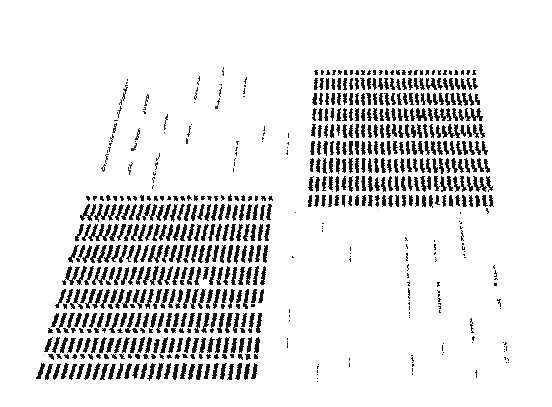